In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.reset_orig()


from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
from statsmodels.tools.sm_exceptions import  ValueWarning 
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)

from utils.constants import *

In [2]:
start_index = HOURS_PER_YEAR + HOURS_PER_MONTH
training_length = HOURS_PER_WEEK
testing_length = HOURS_PER_DAY

In [3]:
data = pd.read_csv('2022_2023/2023_data_with_imbalance.csv', index_col=0)
data.drop(columns=['forward_FC','production_RE','Offshore DK1','Onshore DK1'], inplace=True)
data.head()

,forward_RE,prices_SB,production_FC,Offshore DK2,Onshore DK2,day_ahead_gen,day_ahead_solar_gen,day_ahead_wind_offshore_gen,day_ahead_wind_onshore_gen,day_ahead_load
0,41.33,41.33,1.000000,0.274701,0.680247,1736.0,0.0,311.0,245,1340
1,42.18,42.18,1.000000,0.356135,0.796296,1745.0,0.0,316.0,263,1280
2,44.37,44.37,0.776486,0.279045,0.728395,1710.0,0.0,294.0,253,1238
3,37.67,37.67,0.935938,0.228013,0.698765,1603.0,0.0,294.0,235,1212
4,39.70,39.70,1.000000,0.221498,0.690123,1451.0,0.0,280.0,215,1205


<Axes: >

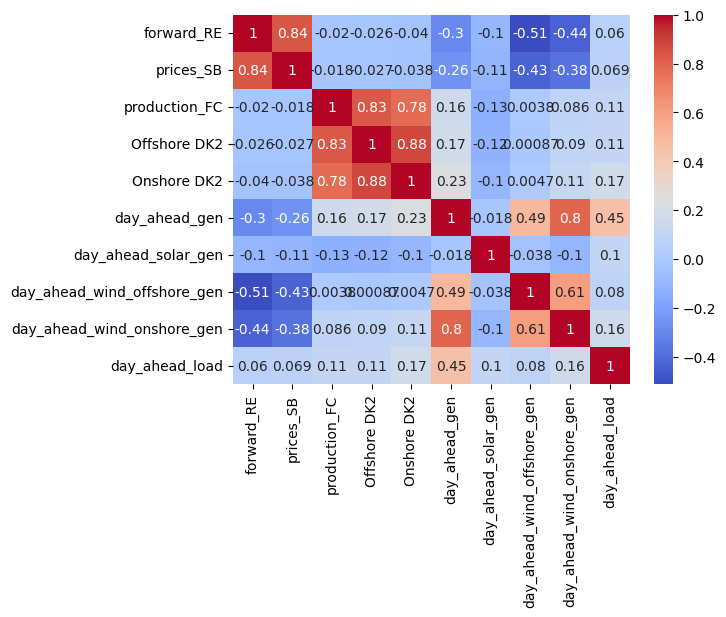

In [4]:
#Correlation heatmap
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

In [5]:
data.drop(columns=['day_ahead_load','production_FC','Offshore DK2','Onshore DK2'], inplace=True)

In [6]:
data['prices_diff'] = data['forward_RE'] - data['prices_SB']

In [11]:
datalag = pd.DataFrame()
# Add 24 columns for the previous 24 prices_diff
for i in range(1, 25):
    datalag[f'prices_diff_{i}'] = data['prices_diff'].shift(i)
    # data[f'prices_SB{i}'] = data['prices_SB'].shift(i)
    
data.dropna(inplace=True)

In [12]:
data['balancing_state'] = np.where(data['prices_diff'] > 0, 0, np.where(data['prices_diff'] == 0, 1, 2))

In [13]:
data.head(20)

,forward_RE,prices_SB,day_ahead_gen,day_ahead_solar_gen,day_ahead_wind_offshore_gen,day_ahead_wind_onshore_gen,prices_diff,balancing_state
0,41.33,41.33,1736.0,0.0,311.0,245,0.00,1
1,42.18,42.18,1745.0,0.0,316.0,263,0.00,1
2,44.37,44.37,1710.0,0.0,294.0,253,0.00,1
3,37.67,37.67,1603.0,0.0,294.0,235,0.00,1
4,39.70,39.70,1451.0,0.0,280.0,215,0.00,1
5,40.59,40.59,1533.0,0.0,289.0,209,0.00,1
6,43.26,43.26,1557.0,0.0,302.0,192,0.00,1
7,49.66,43.14,1638.0,0.0,287.0,169,6.52,0
8,70.05,43.13,1485.0,2.0,261.0,134,26.92,0
9,76.79,50.00,1413.0,8.0,241.0,94,26.79,0


<Axes: >

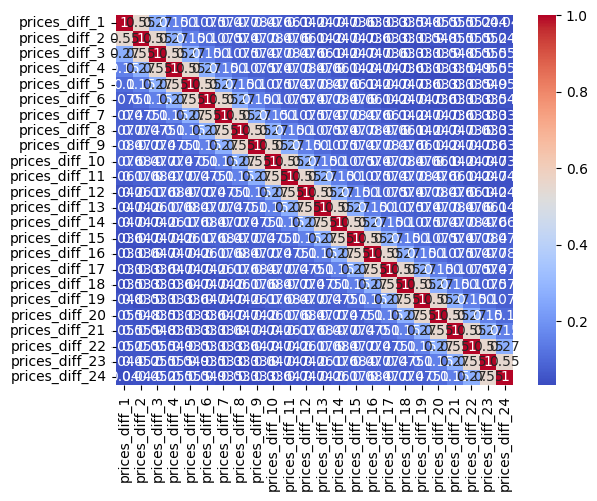

In [14]:
#Correlation heatmap
sns.heatmap(datalag.corr(), annot=True, cmap='coolwarm')

0.7317510874542125


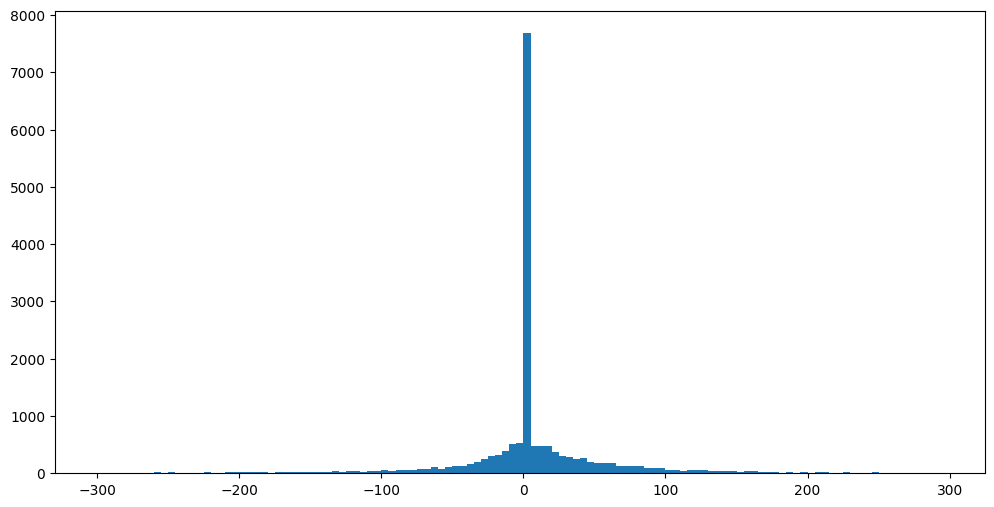

In [11]:
#Plot a histogram of prices diff for every hour (%24 hours)
bins_edges = np.arange(-300, 300, 5)
print(np.mean(data['prices_diff']))
plt.figure(figsize=(12,6))
plt.hist(data['prices_diff'], bins=bins_edges)
plt.show()

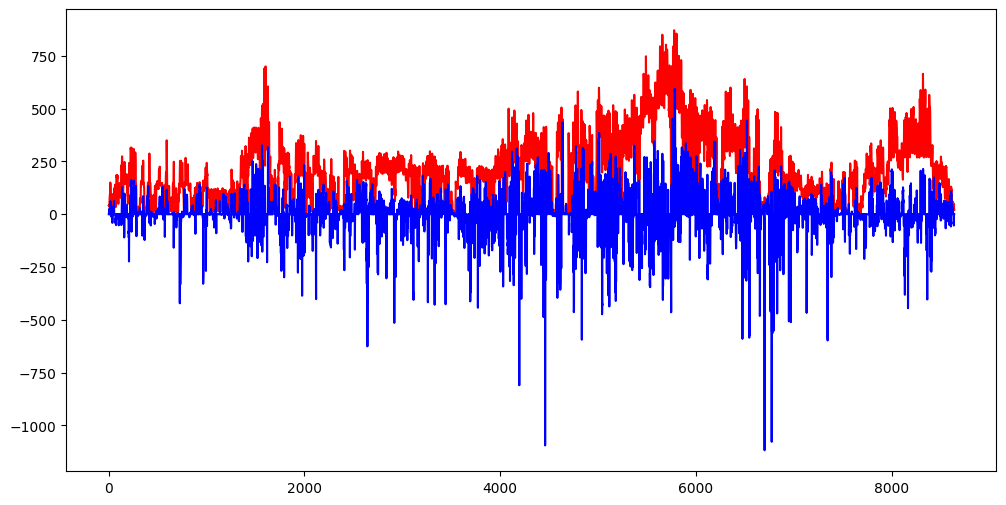

In [47]:
plt.figure(figsize=(12,6))
plt.plot(data['forward_RE'][:HOURS_PER_YEAR],color='red', label='prices_SB')
plt.plot(data['prices_diff'][:HOURS_PER_YEAR],color='blue', label='prices_diff')
plt.show()

## Regression

In [12]:
from xgboost import XGBRegressor
#Random Forest
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

start_index = HOURS_PER_YEAR + HOURS_PER_MONTH
training_length = HOURS_PER_MONTH
testing_length = HOURS_PER_DAY

X = data.drop(columns=['prices_SB'])
y = data['prices_SB']
X_train = X.iloc[start_index-training_length:start_index]
display(X_train)
y_train = y.iloc[start_index-training_length:start_index]

X_test = X.iloc[start_index:start_index+testing_length]
y_test = y.iloc[start_index:start_index+testing_length]

model = RandomForestRegressor()
model.fit(X_train, y_train)

model2 = XGBRegressor()
model2.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred2 = model2.predict(X_test)

,forward_RE,day_ahead_gen,day_ahead_solar_gen,day_ahead_wind_offshore_gen,day_ahead_wind_onshore_gen
8640,9.98,1768.0,0.0,283.0,414
8641,5.69,1787.0,0.0,289.0,430
8642,5.00,1802.0,0.0,299.0,443
8643,11.46,1806.0,0.0,300.0,437
8644,19.59,1803.0,0.0,299.0,411
...,...,...,...,...,...
9355,150.00,1564.0,0.0,115.0,223
9356,100.81,1540.0,0.0,135.0,223
9357,100.78,1521.0,0.0,164.0,213
9358,62.07,1468.0,0.0,183.0,193


In [13]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('----------------')
print('MAE:', mean_absolute_error(y_test, y_pred2))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred2)))

MAE: 41.71565416666666
RMSE: 52.538072029826616
----------------
MAE: 57.69373862584431
RMSE: 73.98039360511436


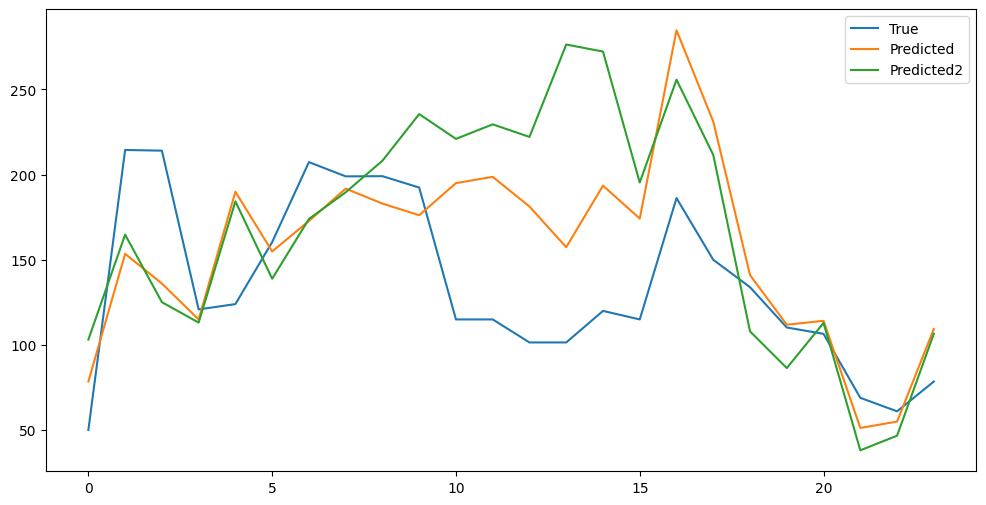

In [14]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.plot(y_pred2, label='Predicted2')
plt.legend()
plt.show()

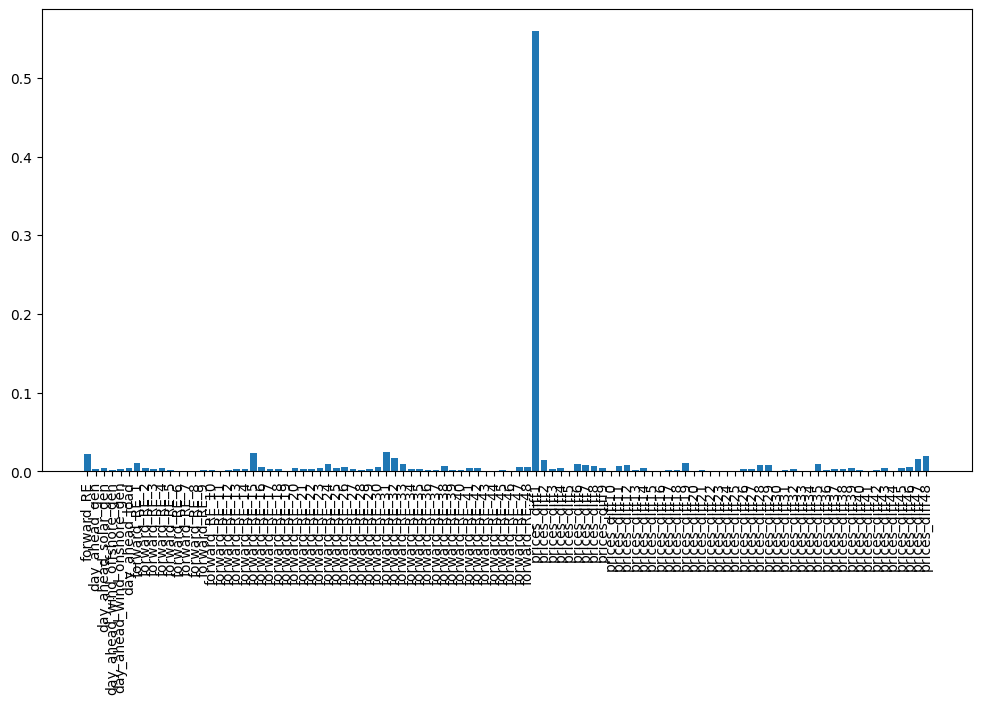

In [13]:
# Feature importance
plt.figure(figsize=(12,6))
plt.bar(X.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

## Classification

In [14]:
data.insert(4, 'State', np.where(data['prices_diff'] > 0, 0, np.where(data['prices_diff'] == 0, 1, 2)))
display(data.head(20))

,forward_RE,prices_SB,prices_diff,day_ahead_gen,State,day_ahead_solar_gen,day_ahead_wind_offshore_gen,day_ahead_wind_onshore_gen,day_ahead_load,forward_RE_1,...,prices_diff39,prices_diff40,prices_diff41,prices_diff42,prices_diff43,prices_diff44,prices_diff45,prices_diff46,prices_diff47,prices_diff48
96,26.90,26.90,0.00,1255,1,0.0,277.0,338.0,1242,31.41,...,-9.56,-10.76,-2.91,0.00,0.00,0.00,0.00,3.67,6.76,9.07
97,25.12,25.12,0.00,1153,1,0.0,270.0,324.0,1210,26.90,...,-8.69,-9.56,-10.76,-2.91,0.00,0.00,0.00,0.00,3.67,6.76
98,24.12,24.12,0.00,1065,1,0.0,259.0,297.0,1202,25.12,...,-10.47,-8.69,-9.56,-10.76,-2.91,0.00,0.00,0.00,0.00,3.67
99,22.04,22.04,0.00,983,1,0.0,240.0,257.0,1216,24.12,...,0.00,-10.47,-8.69,-9.56,-10.76,-2.91,0.00,0.00,0.00,0.00
100,18.37,18.37,0.00,1010,1,0.0,227.0,250.0,1242,22.04,...,-10.13,0.00,-10.47,-8.69,-9.56,-10.76,-2.91,0.00,0.00,0.00
101,22.09,22.09,0.00,1040,1,0.0,206.0,238.0,1303,18.37,...,-12.70,-10.13,0.00,-10.47,-8.69,-9.56,-10.76,-2.91,0.00,0.00
102,23.35,23.35,0.00,1094,1,0.0,192.0,216.0,1405,22.09,...,-15.66,-12.70,-10.13,0.00,-10.47,-8.69,-9.56,-10.76,-2.91,0.00
103,48.22,45.60,-2.62,1191,2,0.0,161.0,199.0,1528,23.35,...,-17.81,-15.66,-12.70,-10.13,0.00,-10.47,-8.69,-9.56,-10.76,-2.91
104,49.99,45.60,-4.39,1145,2,10.0,127.0,173.0,1646,48.22,...,-18.07,-17.81,-15.66,-12.70,-10.13,0.00,-10.47,-8.69,-9.56,-10.76
105,50.73,46.11,-4.62,1163,2,27.0,124.0,151.0,1732,49.99,...,0.00,-18.07,-17.81,-15.66,-12.70,-10.13,0.00,-10.47,-8.69,-9.56


In [16]:
#XGBoost
from xgboost import XGBClassifier
# import minmaxscaler
from sklearn.preprocessing import MinMaxScaler

X = data.drop(columns=['prices_diff', 'prices_SB','balancing_state'])
y = data['balancing_state']
X_train = X.iloc[start_index-training_length:start_index]
y_train = y.iloc[start_index-training_length:start_index]


X_test = X.iloc[start_index:start_index+testing_length]
y_test = y.iloc[start_index:start_index+testing_length]

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 1.0


In [14]:
print('MAE:', np.mean(np.abs(y_test - y_pred)))
print('RMSE:', np.sqrt(np.mean((y_test - y_pred)**2)))

MAE: 0.7916666666666666
RMSE: 0.9354143466934853


In [15]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)


array([[1, 5, 0],
       [3, 4, 8],
       [1, 1, 1]], dtype=int64)

# ARIMAX

In [20]:
# Perform statistical tests to check the stationarity of the time series
from statsmodels.tsa.stattools import adfuller

def adf_test(series, signif=0.05):
    dftest = adfuller(series, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [21]:
adf_test(data['prices_SB'])

Test Statistic         -1.533431e+01
p-value                 3.907639e-28
# Lags                  3.000000e+01
# Observations          1.736900e+04
Critical Value (1%)    -3.430727e+00
Critical Value (5%)    -2.861706e+00
Critical Value (10%)   -2.566859e+00
dtype: float64
 Series is Stationary


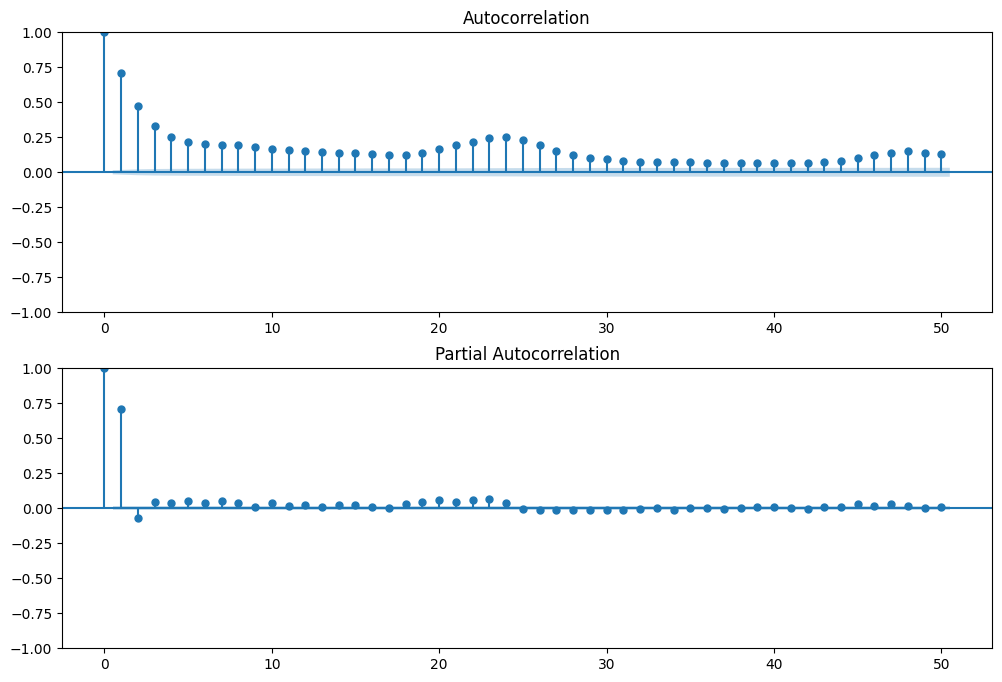

In [23]:
# acf and pacf plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['prices_SB'], lags=50, ax=ax[0])
plot_pacf(data['prices_SB'], lags=50, ax=ax[1])
plt.show()

In [20]:
arima_data = data.drop(['prices_SB'], axis=1)
arima_labels = data['prices_SB']
display(arima_data.head())
display(arima_labels.head())

,forward_RE,day_ahead_wind_offshore_gen,day_ahead_wind_onshore_gen,day_ahead_load
0,28.32,328.0,645.0,1321
1,10.07,257.0,590.0,1296
2,-4.08,210.0,566.0,1242
3,-9.91,204.0,559.0,1211
4,-7.41,204.0,557.0,1208


0    28.32
1    10.07
2    -4.08
3    -9.91
4    -7.41
Name: prices_SB, dtype: float64

In [40]:
model = SARIMAX(data['prices_SB'][start_index-training_length:start_index].to_numpy(), order=(12,0,0), seasonal_order=(4,0,0,24))
model_fit = model.fit(maxiter=200)
y_pred = model_fit.forecast(testing_length)

In [41]:
print('MAE:', mean_absolute_error(data['prices_SB'][start_index:start_index+testing_length], y_pred))

MAE: 3.2788413886143086


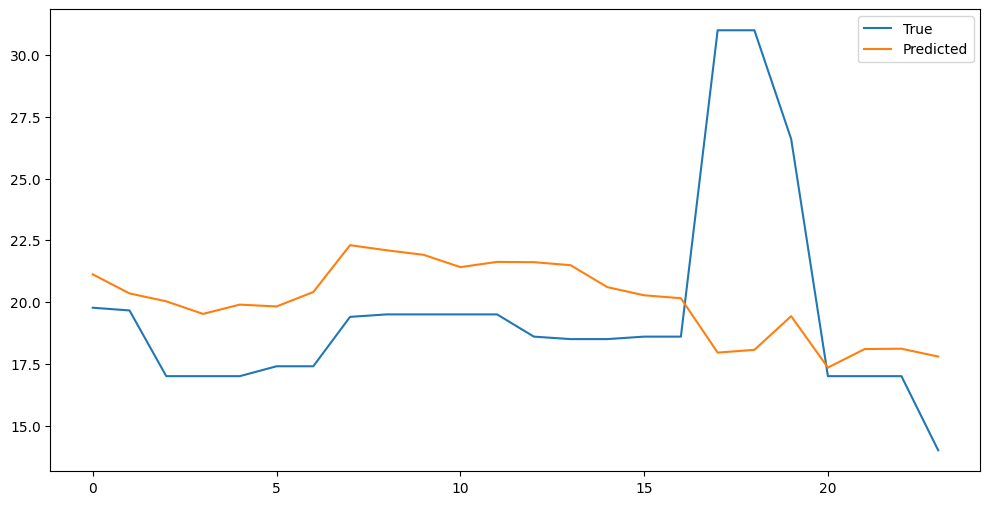

In [42]:
plt.figure(figsize=(12,6))
plt.plot(data['prices_SB'][start_index:start_index+testing_length].to_numpy(), label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()